In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import scipy.stats as stats2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Non-Uniform Label Smoothing for DR grading
In this paper, we introduce a new way of manipulating labels.

## Numpy implementation
### Standard Label Smoothing:
For this to work, we need our labels to be one-hot encoded. For the sake of illustration, let us assume our problem has 5 different classes, and let us fix our label to be `l=2` here. 

In [2]:
n_classes = 5
l = 2

One can easily one-hot encode such label with a one-liner in `numpy`:

In [3]:
def one_hot_encoding(l, n_classes):
    return np.eye(n_classes)[l]

In [4]:
one_hot = one_hot_encoding(l, n_classes)
one_hot

array([0., 0., 1., 0., 0.])

Now, in order to implement Label Smoothing, we first need a uniform distribution sampled such that it has the same size as `one_hot`:

In [5]:
uniform = np.ones_like(one_hot)/n_classes
uniform

array([0.2, 0.2, 0.2, 0.2, 0.2])

We then need to assign a weight for each of both representations, and the Uniform Label Smoothing scheme is easily built out of them:

In [6]:
alpha = 0.2
soft_labels = (1 - alpha)*one_hot + alpha*uniform
soft_labels

array([0.04, 0.04, 0.84, 0.04, 0.04])

Or in a single function:

In [7]:
def get_uniform_label_smoothing(l, n_classes, alpha=0.2):
    one_hot = one_hot_encoding(l, n_classes)
    uniform = np.ones_like(one_hot)/n_classes
    return (1 - alpha)*one_hot + alpha*uniform

In [8]:
get_uniform_label_smoothing(l, n_classes=5, alpha = 0.2)

array([0.04, 0.04, 0.84, 0.04, 0.04])

### Non-Uniform Label Smoothing:
The key here is that there is some relationship in the labels that Label Smoothing is ignoring. Namely, a given label is closer to its neighbors than to further away one. Motivated by this, we first build a set of Gaussian distribution samplings, centered at each class, as follows:

In [9]:
def get_gaussian_label_distribution(n_classes, std=0.5):
    CLs = []
    for l in range(n_classes):
        CLs.append(stats2.norm.pdf(np.arange(n_classes), l, std))
    dists = np.stack(CLs, axis=0)
    return dists

In [10]:
dist = get_gaussian_label_distribution(n_classes)

Now we can simply access `dist` at the row corresponding to the label we want to smooth, and we are done:

In [11]:
np.around(dist[l], 3)

array([0.   , 0.108, 0.798, 0.108, 0.   ])

Or in a single function:

In [12]:
def get_non_uniform_label_smoothing(l, n_classes, std=0.5):
    dist = get_gaussian_label_distribution(n_classes, std=std)
    return dist[l]

In [13]:
get_non_uniform_label_smoothing(l, n_classes=5, std = 0.75)

array([0.01519465, 0.2186801 , 0.53192304, 0.2186801 , 0.01519465])

Let us visualize the difference in a plot. We exaggerate a bit the `alpha` weight in uniform label smoothing and the standard deviation in non-uniform label smoothing to better appreciate what's going on:

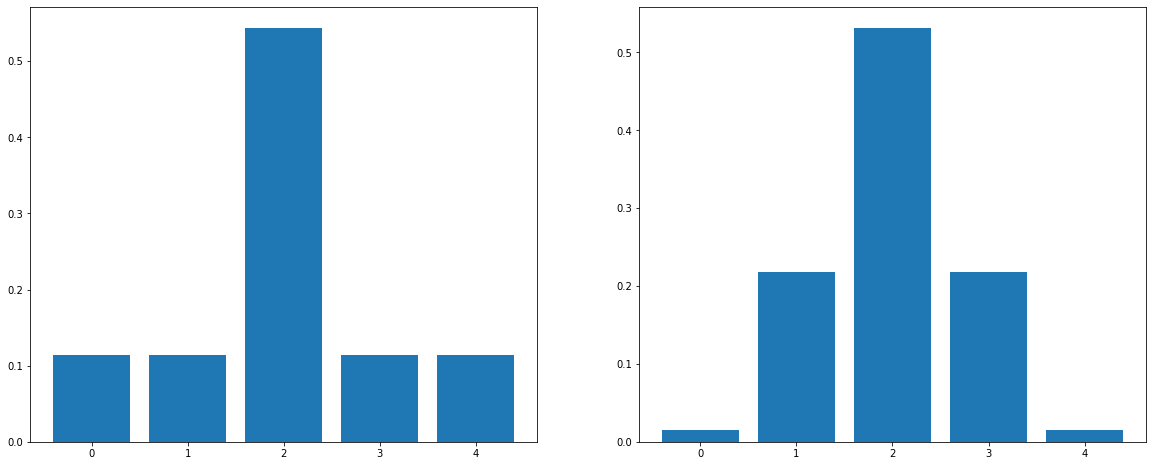

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))
ax[0].bar(np.arange(n_classes), get_uniform_label_smoothing(l, n_classes, alpha = 0.57))
ax[1].bar(np.arange(n_classes), get_non_uniform_label_smoothing(l, n_classes, std = 0.75))
plt.show()

Note that the above implementation should work for any amount of classes.

## PyTorch implementation
### Standard Label Smoothing:
Again, we assume our problem has 5 different classes, and let us fix our label to be `l=2` here. 

In [15]:
n_classes = 5
l_tens = torch.Tensor([2]).long()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def one_hot_encoding_torch(l, n_classes):
    return torch.zeros(l.size(0), n_classes).to(l.device).scatter_(1, l.view(-1, 1), 1)

In [18]:
one_hot = one_hot_encoding_torch(l_tens, n_classes)
one_hot

tensor([[0., 0., 1., 0., 0.]])

In [19]:
uniform = torch.ones_like(one_hot)/n_classes
uniform

tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]])

In [20]:
alpha = 0.2
soft_labels = (1 - alpha)*one_hot + alpha*uniform
soft_labels

tensor([[0.0400, 0.0400, 0.8400, 0.0400, 0.0400]])

In [21]:
def get_uniform_label_smoothing_torch(l, n_classes, alpha=0.2):
    one_hot = one_hot_encoding_torch(l, n_classes)
    uniform = torch.ones_like(one_hot)/n_classes
    return (1 - alpha)*one_hot + alpha*uniform

In [22]:
get_uniform_label_smoothing_torch(l_tens, n_classes=5, alpha = 0.2)

tensor([[0.0400, 0.0400, 0.8400, 0.0400, 0.0400]])

See if it works with a batch of labels:

In [23]:
l_tens = torch.Tensor([0,1,2,3,4]).long()

In [24]:
get_uniform_label_smoothing_torch(l_tens, n_classes=5, alpha = 0.2)

tensor([[0.8400, 0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.8400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.8400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.8400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.8400]])

In [25]:
batch = get_uniform_label_smoothing_torch(l_tens, n_classes=5, alpha = 0.2)

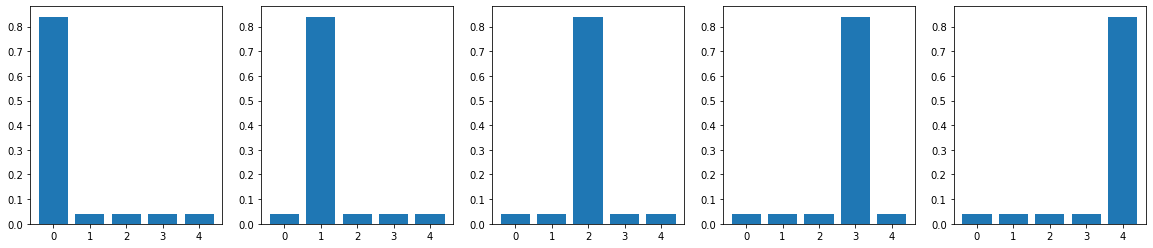

In [26]:
fig, ax = plt.subplots(ncols=5, figsize=(20,4))
for i in range(n_classes):
    ax[i].bar(np.arange(n_classes), batch[i])
plt.show()

### Non-Uniform Label Smoothing:

In [27]:
l_tens = torch.Tensor([2]).long()

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [29]:
l_tens.device

device(type='cpu')

In [30]:
def get_non_uniform_label_smoothing(l_tens, n_classes, std=0.5):
    device = l_tens.device
    dist = get_gaussian_label_distribution(n_classes, std = std)
    if device is not 'cpu':
        soft_labels = torch.from_numpy(dist[l_tens.cpu().numpy()]).to(device)
    else:
        soft_labels = torch.from_numpy(dist[labels.numpy()])
    return soft_labels

In [31]:
get_non_uniform_label_smoothing(l_tens, n_classes=5, std = 0.5)

tensor([[2.6766e-04, 1.0798e-01, 7.9788e-01, 1.0798e-01, 2.6766e-04]],
       dtype=torch.float64)

See if it works with a batch of labels:

In [32]:
l_tens = torch.Tensor([0,1,2,3,4]).long()

In [33]:
batch = get_non_uniform_label_smoothing(l_tens, n_classes=5, std = 0.75)

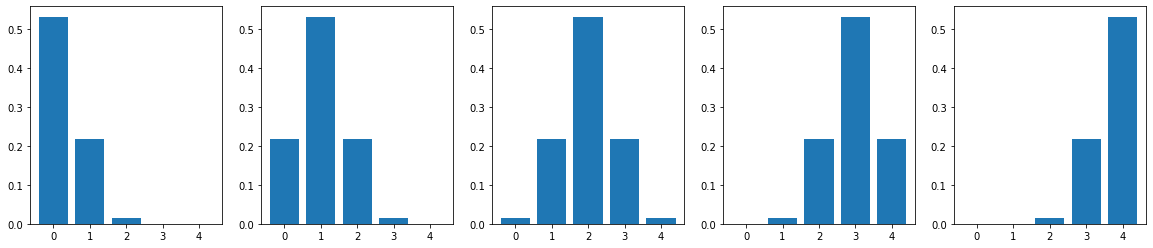

In [34]:
fig, ax = plt.subplots(ncols=5, figsize=(20,4))
for i in range(n_classes):
    ax[i].bar(np.arange(n_classes), batch[i])
plt.show()

### Encapsulating the whole thing
We will be needing a version of `torch.CrossEntropyLoss()` that can handle one hot encoded labels:

In [35]:
def cross_entropy_loss_one_hot(logits, target, reduction='mean'):
    logp = F.log_softmax(logits, dim=1)
    loss = torch.sum(-logp * target, dim=1)
    if reduction == 'none':
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        raise ValueError(
            '`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

With this, we can encapsulate both label smoothing flavors in a single function that will return the appropriate loss function to be used as criterion:

In [36]:
def label_smoothing_criterion(distribution='uniform', alpha=0.1, std =0.5, reduction='mean'):
    '''
    distribution can be ''uniform' or 'non-uniform'
    '''
    def _cross_entropy_loss_one_hot(logits, target, reduction='mean'):
        logp = F.log_softmax(logits, dim=1)
        loss = torch.sum(-logp * target, dim=1)
        if reduction == 'none':
            return loss
        elif reduction == 'mean':
            return loss.mean()
        elif reduction == 'sum':
            return loss.sum()
        else:
            raise ValueError(
                '`reduction` must be one of \'none\', \'mean\', or \'sum\'.')
    def _get_gaussian_label_distribution(n_classes, std=0.5):
        CLs = []
        for l in range(n_classes):
            CLs.append(stats2.norm.pdf(np.arange(n_classes), l, std))
        dists = np.stack(CLs, axis=0)
        return dists
    
    def _one_hot_encoding_torch(l, n_classes):
        return torch.zeros(l.size(0), n_classes).to(l.device).scatter_(1, l.view(-1, 1), 1)
    
    def _label_smoothing_criterion(logits, labels):
        n_classes = logits.size(1)
        device = logits.device
        if distribution == 'uniform':
            one_hot = _one_hot_encoding_torch(labels, n_classes)
            uniform = torch.ones_like(one_hot)/n_classes
            soft_labels =  (1 - alpha)*one_hot + alpha*uniform
        elif distribution == 'non-uniform':
            dist = _get_gaussian_label_distribution(n_classes, std=std)
            if device is not 'cpu':
                soft_labels = torch.from_numpy(dist[labels.cpu().numpy()]).to(device)
            else:
                soft_labels = torch.from_numpy(dist[labels.numpy()])
        else:
            print('Not implemented')
            
        loss = _cross_entropy_loss_one_hot(logits, soft_labels.float(), reduction)
        return loss
    return _label_smoothing_criterion

In [37]:
loss_fn_ULS = label_smoothing_criterion(distribution='uniform', alpha=0.1)
loss_fn_NULS = label_smoothing_criterion(distribution='non-uniform', std=0.75)

In [38]:
labels = torch.Tensor([4]).long().unsqueeze(dim=0)
labels.shape

torch.Size([1, 1])

In [39]:
logits_wrong = torch.Tensor([1, 0, 0, 0, 0]).float().unsqueeze(dim=0)
logits_better = torch.Tensor([0, 0, 0, 1, 0]).float().unsqueeze(dim=0)

In [40]:
loss_fn_ULS(logits_wrong, labels), loss_fn_ULS(logits_better, labels)

(tensor(1.8848), tensor(1.8848))

In [41]:
loss_fn_NULS(logits_wrong, labels), loss_fn_NULS(logits_better, labels)

(tensor(0.2918), tensor(0.2481))

### Using it in your code
Simply import from the associated `n_uls.py` file:

In [42]:
from n_uls import label_smoothing_criterion as ls_loss

In [43]:
loss_fn_ULS = ls_loss(distribution='uniform', alpha=0.1)
loss_fn_NULS = ls_loss(distribution='non-uniform', std=0.75)

In [44]:
loss_fn_ULS(logits_wrong, labels), loss_fn_ULS(logits_better, labels)

(tensor(1.8848), tensor(1.8848))

In [45]:
loss_fn_NULS(logits_wrong, labels), loss_fn_NULS(logits_better, labels)

(tensor(0.2918), tensor(0.2481))